# In this Jupyter Notebook

## <br>I aim to demonstrate the purpose and methodology behind three approaches to modeling time series data, corresponding to three different files executing each of the approaches.

### 1. Reading in the data <br> 2. Using Facebook's Prophet in Python <br> 3. Using Gaussing Process Regression in Python <br>4.  Using SARIMA process fitting in Python and R

# Before performing any modeling or analysis we must import relevant packages and read in the data for the Facebook Stock Prices

### Reading in the Relevant Packages

In [3]:
### Import all the relevant Packages to be used in this Analysis
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn import metrics
## This is the Facebook Prophet Package which has the relevant analytical methods
import fbprophet

##### pandas: \\\ used for creating and manipulating dataframe objects. <br> <br> pandas_datareader.data: \\\ used for getting stock data from a remote source, here that source is quandl. <br><br>  matplotlib.pyplot: \\\ used for creating figures, and a variety of plots to visualize data <br><br>  numpy: \\\ used for a variety of operations usually to do with math, but also with array operations <br><br>  datetime: \\\ used for creating a datetime object to be used as an input to the pandas_datareader.data DataReader function <br><br>  sklearn.metrics: \\\ used to print out a variety of goodness of fit/error/residual metrics <br><br> fbprophet: \\\ used to perform the relevant modeling methods

## Importing the data for Facebook's Stock Price History

In [44]:
start = datetime.datetime(2013, 1, 1)
mid = datetime.datetime(2017,6,1)
end = datetime.datetime(2018, 1, 1)

#fm = data.DataReader('F', 'morningstar', start, end)

# Creates a pandas DataFrame object with stock price and other related data such as Volume and dividends
df = data.DataReader('F', 'quandl', start, end)


# Reverse the order of rows in the data so that the first row corresponds to the first time point
df = df.iloc[::-1]

print(df.head())
print(df.columns)

             Open    High    Low  Close       Volume  ExDividend  SplitRatio  \
Date                                                                           
2013-01-02  13.23  13.280  13.00  13.20   75274700.0         0.0         1.0   
2013-01-03  13.24  13.695  13.05  13.46  121284700.0         0.0         1.0   
2013-01-04  13.51  13.610  13.35  13.57   54669900.0         0.0         1.0   
2013-01-07  13.52  13.580  13.35  13.43   43482400.0         0.0         1.0   
2013-01-08  13.38  13.430  13.20  13.35   46336200.0         0.0         1.0   

              AdjOpen    AdjHigh     AdjLow   AdjClose    AdjVolume  
Date                                                                 
2013-01-02  10.621678  10.661820  10.437023  10.597592   75274700.0  
2013-01-03  10.629706  10.995002  10.477165  10.806333  121284700.0  
2013-01-04  10.846475  10.926760  10.718020  10.894646   54669900.0  
2013-01-07  10.854504  10.902675  10.718020  10.782247   43482400.0  
2013-01-08  10.7421

## Create some relevant variables based on AdjClose

In [42]:
# Create a Differenced Adjusted Close Variable in an attempt to remove the trend in the Adjusted Close data
df["DAC"] = df["AdjClose"].diff()

# Create a Log Adjusted Close Variable in an attempt to remove heteroskedacity in the Adjusted Close data
df["LAC"] = np.log(df["AdjClose"])

# Create a Differenced Log Adjusted Close Variable in an attempt to first remove the heteroskedacity
# and then remove the trend by taking the log and then differencing
df["DLAC"] = np.log(df["AdjClose"]).diff()

# The Prophet modeling method requires that the input be two vectors with the respective titles "ds" and "y"
df["ds"] = df.index
df["y"] = df["AdjClose"]

df["Dates"] = pd.to_datetime(df["ds"])
df["Year"] = df["Dates"].dt.year
df["Mo"] = df["Dates"].dt.month
df["Day"] = df["Dates"].dt.day

df = df.dropna(inplace=False)

## Plot these variables over time

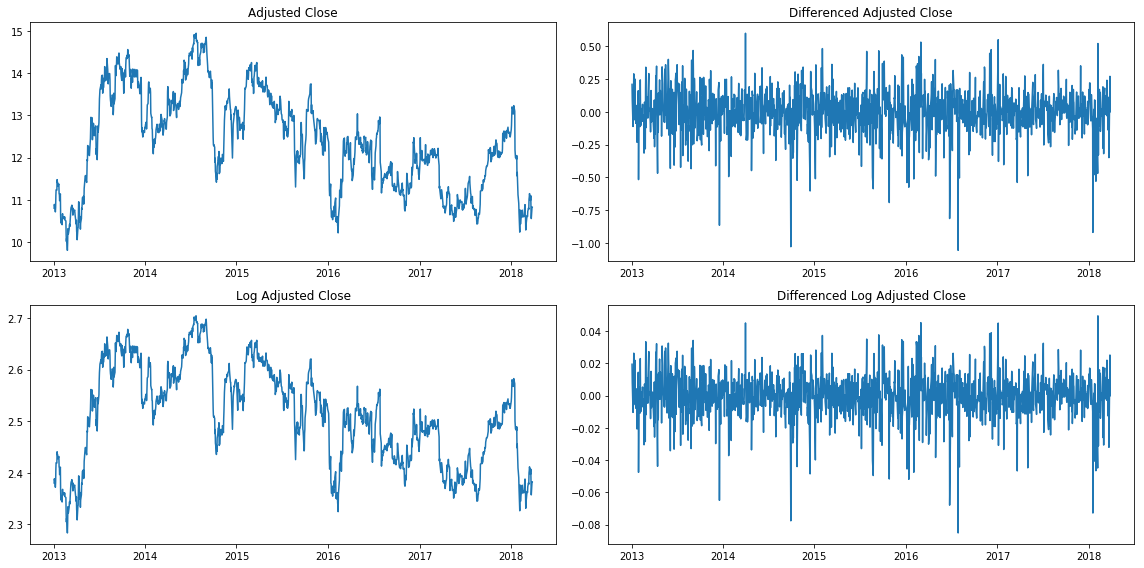

In [43]:
fig = plt.figure(1,figsize=[16,8])
ax1 = fig.add_subplot(221)
plt.title("Adjusted Close")
ax2 = fig.add_subplot(222)
plt.title("Differenced Adjusted Close")
ax3 = fig.add_subplot(223)
plt.title("Log Adjusted Close")
ax4 = fig.add_subplot(224)
plt.title("Differenced Log Adjusted Close")
ax1.plot(df.index, df["AdjClose"])
ax2.plot(df.index, df["DAC"])
ax3.plot(df.index, df['LAC'])
ax4.plot(df.index, df["DLAC"])
plt.tight_layout()
plt.show()

## For the purposes of modeling we need a train and test set, so that we can use the train set to create the model, and use the test set to see how good the model is at forecasting new data

In [25]:
df_train = df.loc[start:mid,:]
df_test  = df.loc[mid:end,:]

p_train = df_train.loc[:,["ds","y"]]
p_test = df_test.loc[:,["ds","y"]]

# 1. The First Method: Using Facebook's Prophet Package

## Using the prophet package for forecasting works in the following format:<br>
### 1. use the Prophet method in fbprophet to create a prophet object <br> 2. Fit the model on the train data <br> Make a future dataframe of a specified length of the forecast <br> forecast the values for the future dataframe

### The function that is being modeled is in the form y(t) = g(t) + s(t) + h(t) + e(t) where g(t) is the growth or trend, s(t) is the seasonal adjustments, and h(t) is holiday adjustments. e(t) is the error. 
### Also, the predict function generates a variety of values pertaining to a ranges of confidence. 

In [175]:
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.1,yearly_seasonality=True,daily_seasonality=True)
gm_prophet.fit(p_train)

gm_forecast = gm_prophet.make_future_dataframe(periods=183, freq='D')

gm_forecast = gm_prophet.predict(gm_forecast)
yhat = gm_forecast[["yhat"]]
yhat = yhat[-len(p_test["y"]):]

/Users/williamnutter/anaconda/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


## Here I am printing out a few of the most commonly used measures of fit for regression problems. They look at a variety of ways to measure how different the predicted values are from the actual values. The following measures are evaluated on just the test data. We could also measure these over the whole dataset, but the true test of the goodness of fit is on data the model was not trained on. To be clear, the model here is the prophet model type with certain parameters like the changepoint prior scale and boolean values for yearly or daily seasonality, not the specific result of training the model on our train data.

In [176]:
print("The Root Mean Squared Error is: "+str(np.sqrt(metrics.mean_squared_error(p_test[["y"]],yhat))))
print("The Mean Squared Error is: "+str(metrics.mean_squared_error(p_test[["y"]],yhat)))
print("The Explained Variance Score is: "+str(metrics.explained_variance_score(p_test[["y"]],yhat)))
print("The R Squared Score is: "+str(metrics.r2_score(p_test[["y"]],yhat)))

## we create this function as a measure of fit of our model
## because it is not implemented in the sklearn.metrics packages
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print("The MAPE is: "+str(mean_absolute_percentage_error(p_test[["y"]],yhat)))

The Root Mean Squared Error is: 1.6190125303217504
The Mean Squared Error is: 2.6212015733388365
The Explained Variance Score is: -0.6348412269117836
The R Squared Score is: -4.687156961167132
The MAPE is: 11.43726388575914


## Here I plot the forecasted and the actual values for the test range in the same plot. It doesn't look particularly well performing to be honest. But that is why errors are useful, and also we may be able to tune the model to get a more useful result. 

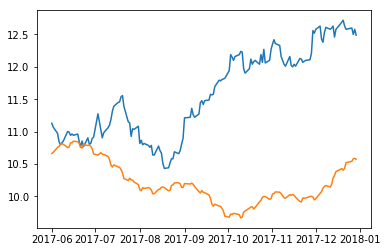

In [177]:
plt.plot(p_test["ds"],p_test["y"])
plt.plot(p_test["ds"],yhat)
plt.show()

# Here I plot the actual values on the x-axis and the forecasted values on the y-axis. I also plot a line representing perfect correspondence to the actual values. Any vertical distance from the line represents the dfference between the actual and the forecasted at that particular actual value. 

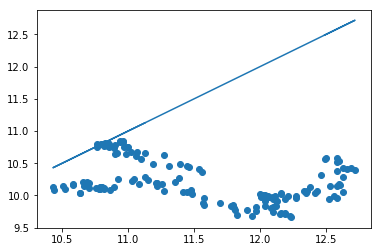

In [178]:
plt.scatter(p_test[["y"]],yhat)
plt.plot(p_test["y"],p_test["y"])
plt.show()

## Here the plot of the full set of data along with the predicted and forecasted values. The actual values are in black, the predicted/forecasted values are in blue, and the confidence range is in light blue.

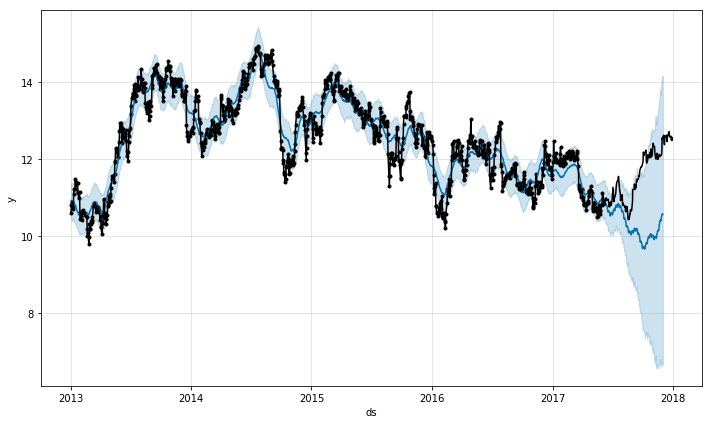

In [179]:
gm_prophet.plot(gm_forecast)
plt.plot(df.index,df["y"],color="black")
plt.show()

## fbprophet also has the functionality to decompose the fitted model into its trend, and the seasonal components.

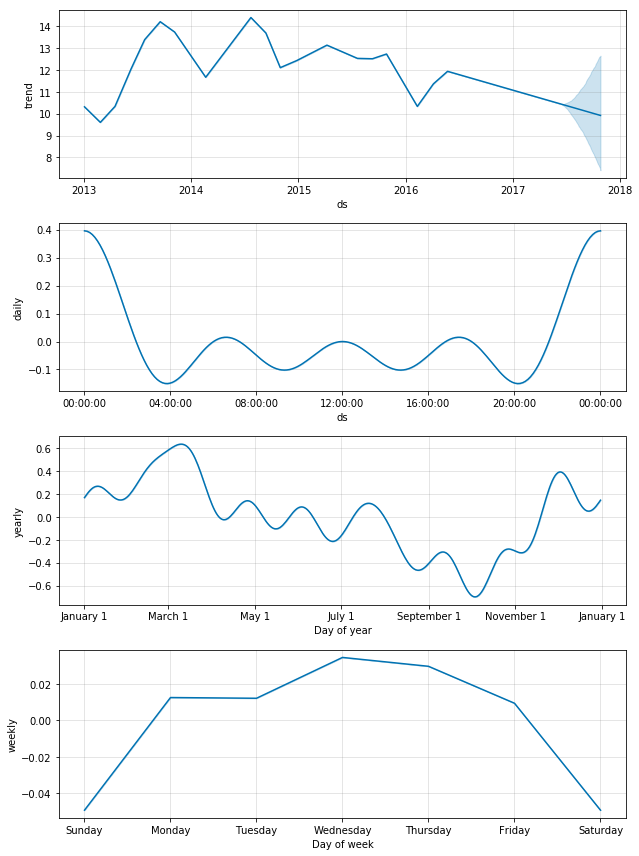

In [174]:
gm_prophet.plot_components(gm_forecast)
plt.show()

# 2. Gaussian Regression with sklearn

## Importing the relevant sklearn packages

In [92]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [121]:
x_whole = np.array((df["Day"],df["Mo"],df["Year"])).T
x_train = (df_train["Day"],df_train["Mo"],df_train["Year"])
x_train = np.array(x_train).T
x_test = (df_test["Day"],df_test["Mo"],df_test["Year"])
x_test = np.array(x_test).T

In [119]:
kernel = C(1, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=RBF(length_scale=20),alpha = .1,normalize_y=True,n_restarts_optimizer=15)


gp.fit(x_train, df_train.loc[:,"y"])

y_pred, sigma = gp.predict(x_whole, return_std=True)

GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
             kernel=RBF(length_scale=20), n_restarts_optimizer=15,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

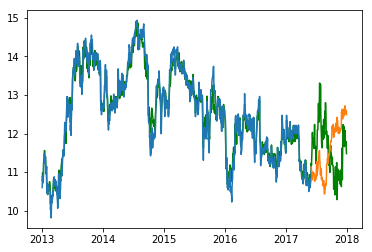

In [126]:
plt.plot(df.index,y_pred,color="G")
plt.plot(df_train.index,df_train["y"])
plt.plot(df_test.index,df_test["y"])
plt.show()

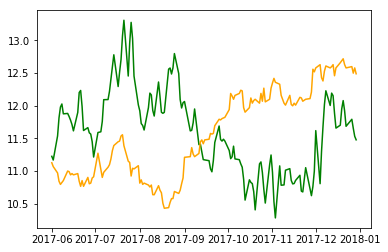

In [145]:
plt.plot(df[mid:end].index,y_pred[-len(df[mid:end].index):],color = "G")
plt.plot(df_test.index,df_test["y"],color="orange")

In [127]:
print("The Root Mean Squared Error is: "+str(np.sqrt(metrics.mean_squared_error(df["y"],y_pred))))
print("The Mean Squared Error is: "+str(metrics.mean_squared_error(df["y"],y_pred)))
print("The MAPE is: "+str(mean_absolute_percentage_error(df["y"],y_pred)))
print("The Explained Variance Score is: "+str(metrics.explained_variance_score(df["y"],y_pred)))
print("The R Squared Score is: "+str(metrics.r2_score(df["y"],y_pred)))

The Root Mean Squared Error is: 0.4288095672415996
The Mean Squared Error is: 0.1838776449579279
The MAPE is: 2.0420543693420363
The Explained Variance Score is: 0.8610445647554082
The R Squared Score is: 0.8610039960281305


# 3. SARIMA 

## Import relevant packages mostly to do with the statsmodels package

In [2]:
import statsmodels.tsa.seasonal as ssnl
from statsmodels.graphics import tsaplots
from pandas import Series as Series
from statsmodels.tsa.stattools import adfuller,arma_order_select_ic,acf,pacf
from statsmodels.tsa.statespace import sarimax

/Users/williamnutter/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


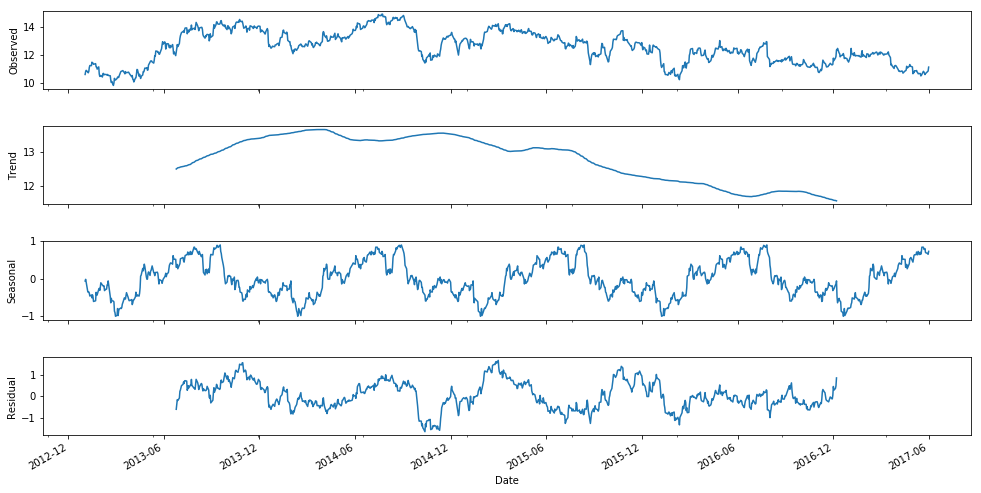

In [7]:
def plt_decomposition():
    decomposition = ssnl.seasonal_decompose(df_train["y"],freq=240)
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)
    plt.show()
    return None

plt_decomposition()

In [8]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    # Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

/Users/williamnutter/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  app.launch_new_instance()
/Users/williamnutter/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


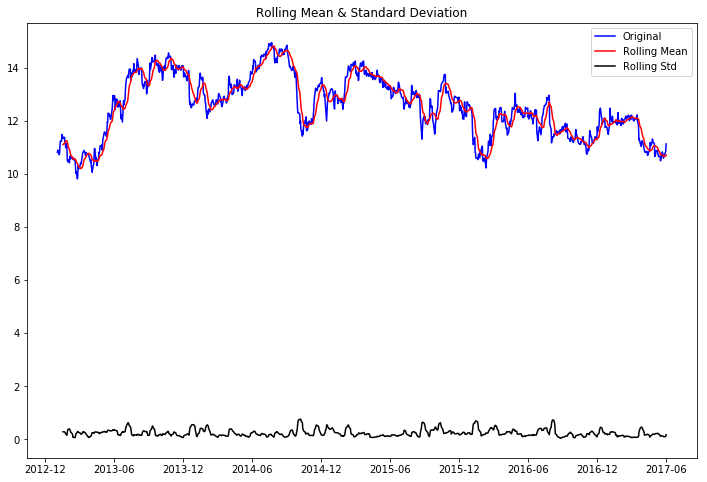

Results of Dickey-Fuller Test:
Test Statistic                   -2.852314
p-value                           0.051181
#Lags Used                        1.000000
Number of Observations Used    1109.000000
Critical Value (10%)             -2.568159
Critical Value (1%)              -3.436260
Critical Value (5%)              -2.864150
dtype: float64


In [26]:
test_stationarity(df_train["AdjClose"])


/Users/williamnutter/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  app.launch_new_instance()
/Users/williamnutter/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


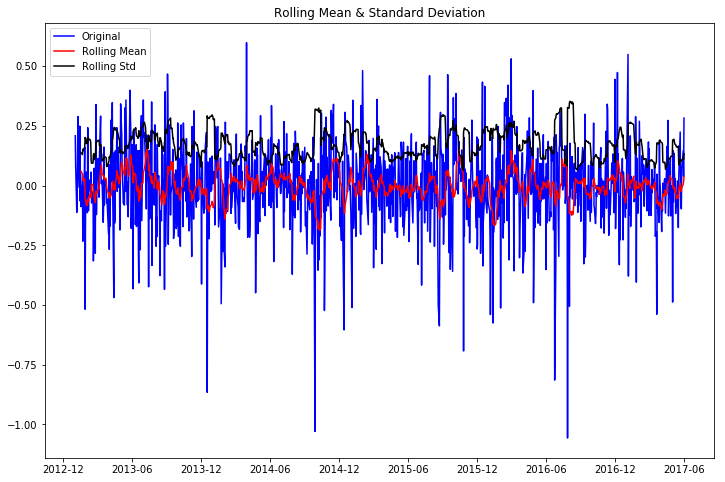

Results of Dickey-Fuller Test:
Test Statistic                  -31.137843
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1110.000000
Critical Value (10%)             -2.568158
Critical Value (1%)              -3.436255
Critical Value (5%)              -2.864147
dtype: float64


In [28]:
np.isnan(df_train["DAC"]).any()
test_stationarity(df_train["DAC"])


/Users/williamnutter/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  app.launch_new_instance()
/Users/williamnutter/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


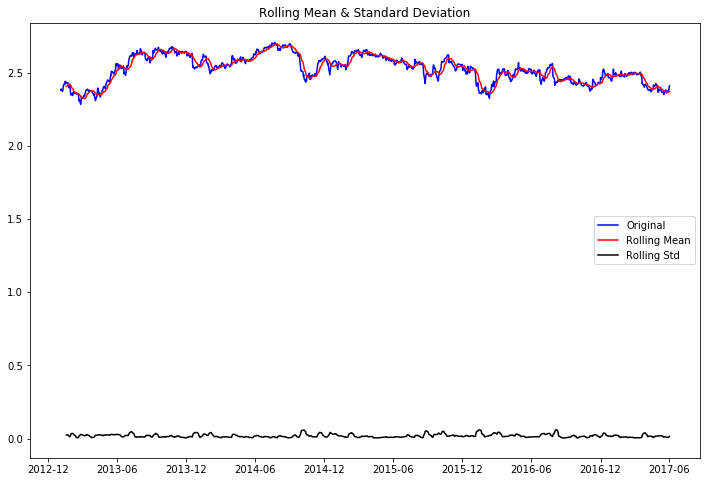

Results of Dickey-Fuller Test:
Test Statistic                   -2.873282
p-value                           0.048544
#Lags Used                        1.000000
Number of Observations Used    1109.000000
Critical Value (10%)             -2.568159
Critical Value (1%)              -3.436260
Critical Value (5%)              -2.864150
dtype: float64


In [29]:
test_stationarity(df_train["LAC"])


/Users/williamnutter/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  app.launch_new_instance()
/Users/williamnutter/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


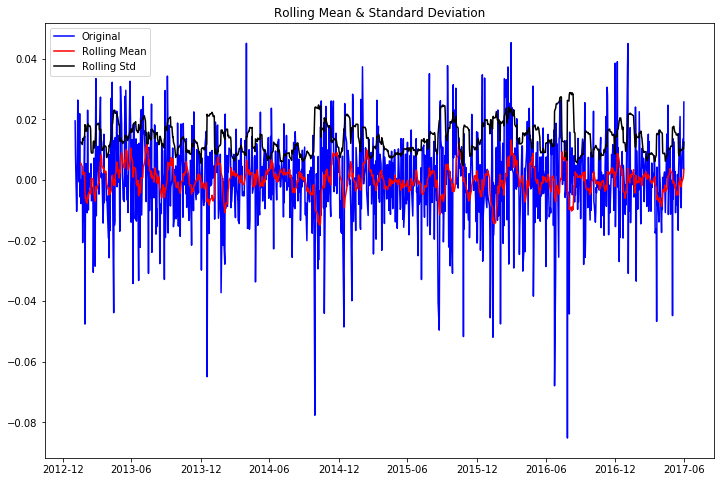

Results of Dickey-Fuller Test:
Test Statistic                  -31.137189
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1110.000000
Critical Value (10%)             -2.568158
Critical Value (1%)              -3.436255
Critical Value (5%)              -2.864147
dtype: float64


In [30]:
test_stationarity(df_train["DLAC"])

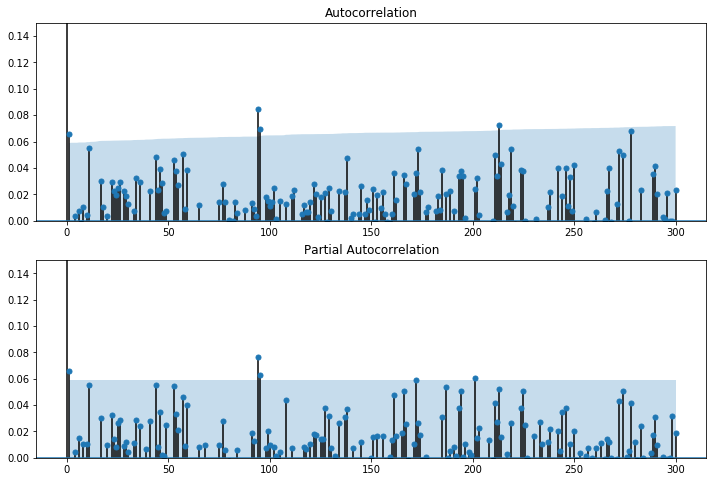

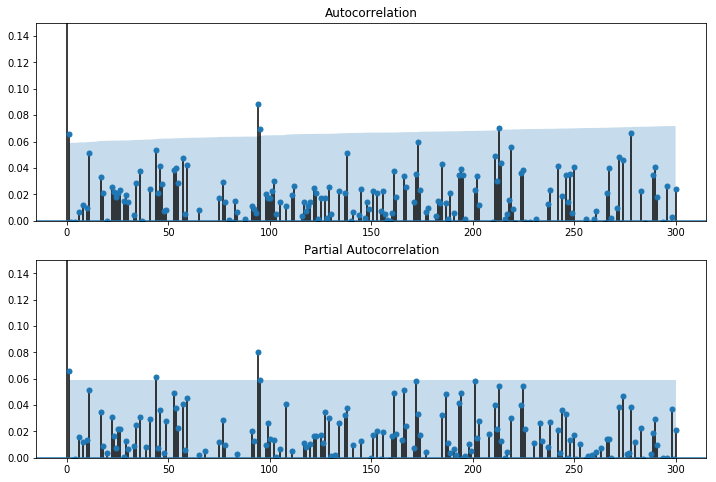

In [72]:
def plt_acf_pacf(d):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    plt.ylim(ymax=.15)
    tsaplots.plot_acf(d,lags=300,ax=ax1)
    ax2 = fig.add_subplot(212)
    plt.ylim(ymax=.15)
    tsaplots.plot_pacf(d,lags=300,ax=ax2)
    plt.show()
    return None

plt_acf_pacf(df_train["DAC"])
plt_acf_pacf(df_train["DLAC"])

In [67]:
res = arma_order_select_ic(df_train["LAC"],max_ar=4,max_ma=4,ic=["aic","bic"])
print(res.aic_min_order)
print(res.bic_min_order)
print(res)
# res = arma_order_select_ic(df_train["DLAC"],max_ar=4,max_ma=4,ic=["aic","bic"])
# print(res.aic_min_order)
# print(res.bic_min_order)
# print(res)

/Users/williamnutter/anaconda/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/williamnutter/anaconda/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/williamnutter/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/williamnutter/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likel

(3, 3)
(1, 0)
{'aic':              0            1            2            3            4
0 -2125.474078 -3423.291832 -4322.938140 -4833.731607 -5203.927931
1 -6236.246616 -6239.941544 -6237.999534 -6236.038823 -6234.311302
2 -6240.000673 -6238.012087 -6237.725925 -6235.979651 -6235.688874
3 -6238.010119 -6236.016824 -6237.950238 -6246.189754 -6237.121081
4 -6236.052273 -6235.752860 -6238.643812 -6236.077578 -6243.136989, 'bic':              0            1            2            3            4
0 -2115.448047 -3408.252785 -4302.886077 -4808.666529 -5173.849836
1 -6221.207568 -6219.889481 -6212.934455 -6205.960728 -6199.220191
2 -6219.948610 -6212.947008 -6207.647830 -6200.888540 -6195.584747
3 -6212.945040 -6205.938729 -6202.859128 -6206.085628 -6192.003939
4 -6205.974178 -6200.661749 -6198.539686 -6190.960436 -6193.006831, 'bic_min_order': (1, 0), 'aic_min_order': (3, 3)}


/Users/williamnutter/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [68]:
mod = sarimax.SARIMAX(df_train["LAC"].values, trend='n', order=(1,2,0), seasonal_order=(1,0,1,95))
results = mod.fit()
print(results.summary())

/Users/williamnutter/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 1111
Model:             SARIMAX(1, 2, 0)x(1, 0, 1, 95)   Log Likelihood                2907.197
Date:                            Mon, 07 May 2018   AIC                          -5806.394
Time:                                    23:02:02   BIC                          -5786.342
Sample:                                         0   HQIC                         -5798.812
                                           - 1111                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4672      0.023    -20.068      0.000      -0.513      -0.422
ar.S.L95      -0.5421      0.243   

In [70]:
mod2 = sarimax.SARIMAX(df_train["LAC"].values, trend='n', order=(3,2,3), seasonal_order=(1,0,1,95))
results2 = mod2.fit()
print(results2.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 1111
Model:             SARIMAX(3, 2, 3)x(1, 0, 1, 95)   Log Likelihood                3115.809
Date:                            Mon, 07 May 2018   AIC                          -6213.618
Time:                                    23:10:00   BIC                          -6168.501
Sample:                                         0   HQIC                         -6196.558
                                           - 1111                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5912      1.356     -0.436      0.663      -3.249       2.066
ar.L2         -0.5810      0.851   

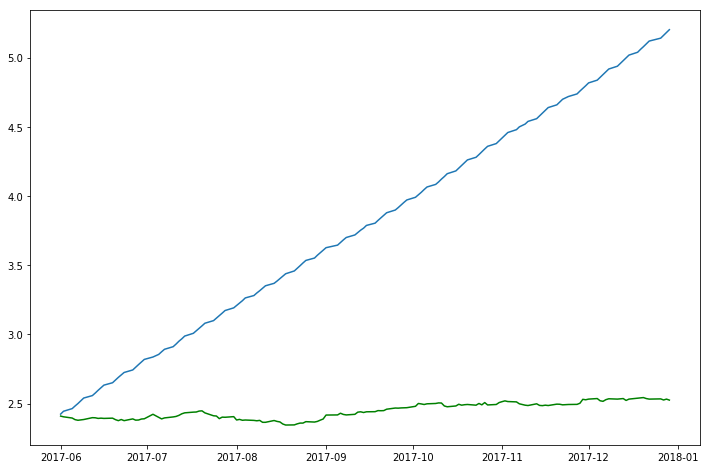

In [69]:
df_test['forecast'] = results.forecast(147)
fig = plt.figure(figsize=(12,8))
# print("forecast: "+str(df_test["forecast"].shape))
# print("actual: "+str(df_test["LAC"].shape))
plt.plot(df_test.index,df_test["LAC"],color="G")
plt.plot(df_test.index,df_test["forecast"])
plt.show()

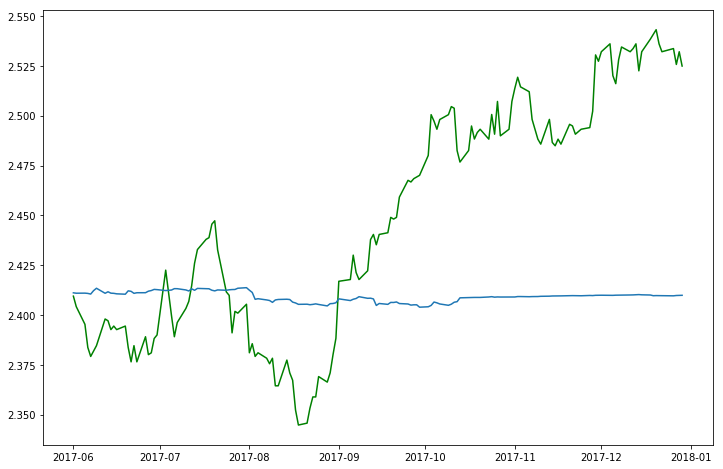

In [71]:
df_test['forecast'] = results2.forecast(147)
fig = plt.figure(figsize=(12,8))
# print("forecast: "+str(df_test["forecast"].shape))
# print("actual: "+str(df_test["LAC"].shape))
plt.plot(df_test.index,df_test["LAC"],color="G")
plt.plot(df_test.index,df_test["forecast"])
plt.show()